In [7]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.backends.backend_pdf import PdfPages
import time
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp

from mpl_toolkits import mplot3d

%matplotlib notebook

# Define the variables
t, r, theta, phi, = sp.symbols('t r theta phi')
dt, dr, dtheta, dphi, M = sp.symbols('dt dr dtheta dphi M')
# Equations of motion in sympy, most other in numpy

In [9]:
# Metric Elements (Schwarzschild)
gtt = -(1 - (2*M/r))
grr = -1/gtt
gthetatheta = r**2
gphiphi = (r**2)*(sp.sin(theta)**2)

g = (sp.Matrix([[gtt, 0, 0, 0], [0, grr, 0, 0], [0, 0, gthetatheta, 0], [0, 0, 0, gphiphi]]))
g

Matrix([
[2*M/r - 1,              0,    0,                  0],
[        0, -1/(2*M/r - 1),    0,                  0],
[        0,              0, r**2,                  0],
[        0,              0,    0, r**2*sin(theta)**2]])

In [10]:
ginv = g.inv()
ginv

Matrix([
[1/(2*M/r - 1),          0,       0,                      0],
[            0, -2*M/r + 1,       0,                      0],
[            0,          0, r**(-2),                      0],
[            0,          0,       0, 1/(r**2*sin(theta)**2)]])

In [13]:
pt, pr, ptheta, pphi, m = sp.symbols('pt pr ptheta pphi m')

# Compute the expression for H
# H = (1/2m)g^(mu,nu)*p_mu*p_nu
Hamil = (1/(2*m)) * (
    ginv[0, 0]* (pt**2) + 
    ginv[1, 1]* (pr**2) + 
    ginv[2, 2]* (ptheta**2) + 
    ginv[3, 3]* (pphi**2)
)

print(sp.simplify(Hamil))
Hamil

(pphi**2/(r**2*sin(theta)**2) - pr**2*(2*M/r - 1) + pt**2/(2*M/r - 1) + ptheta**2/r**2)/(2*m)


(pphi**2/(r**2*sin(theta)**2) + pr**2*(-2*M/r + 1) + pt**2/(2*M/r - 1) + ptheta**2/r**2)/(2*m)

In [14]:
from sympy import diff

# Partial derivatives with respect to pt, pr, p_theta, p_phi,
partial_t = diff(Hamil, t)
partial_pt = diff(Hamil, pt)
partial_r = diff(Hamil, r)
partial_pr = diff(Hamil, pr)
partial_theta = diff(Hamil, theta)
partial_p_theta = diff(Hamil, ptheta)
partial_phi = diff(Hamil, phi)
partial_p_phi = diff(Hamil, pphi)

# Partial H partial t is = dpt/dtau, negative inverses (normal hamiltonian mechanics)
print("dpt/dtau:", -partial_t)
print(" ")
print("dt/dtau:", partial_pt)
print(" ")
print("dpr/dtau:", -partial_r)
print(" ")
print("dr/dtau:", partial_pr)
print(" ")
print("dptheta/dtau:", -partial_theta)
print(" ")
print("dtheta/dtau:", partial_p_theta)
print(" ")
print("dpphi/dtau:", -partial_phi)
print(" ")
print("dphi/dtau:", partial_p_phi)

dpt/dtau: 0
 
dt/dtau: pt/(m*(2*M/r - 1))
 
dpr/dtau: -(2*M*pr**2/r**2 + 2*M*pt**2/(r**2*(2*M/r - 1)**2) - 2*pphi**2/(r**3*sin(theta)**2) - 2*ptheta**2/r**3)/(2*m)
 
dr/dtau: pr*(-2*M/r + 1)/m
 
dptheta/dtau: pphi**2*cos(theta)/(m*r**2*sin(theta)**3)
 
dtheta/dtau: ptheta/(m*r**2)
 
dpphi/dtau: 0
 
dphi/dtau: pphi/(m*r**2*sin(theta)**2)


In [15]:
# Set up the parameters
M = 10000 # Mass of the central black hole 
m = 1 # Mass of the planet 
G = 1 # Gravitational Constant 
c = 1 # Speed of light

#R = 100000000 #Circular orbit
#L = 1000000 #Circular orbit

R = 700000 #Whirl-zoom
L = 39000

pphi = L

In [16]:
def system_of_odes(t,y):
    r, pr, time, pt, theta, ptheta, phi = y     
    
    dRdt = pr*(-2*M/r + 1)/m
    
    dpRdt = -(2*M*pr**2/r**2 + 2*M*pt**2/(r**2*(2*M/r - 1)**2) - 2*pphi**2/(r**3*sp.sin(theta)**2) - 2*ptheta**2/r**3)/(2*m)

    dtimedt = pt/(m*(2*M/r - 1))
    
    dptdt = 0

    dthetadt = ptheta/(m*r**2)
    
    dpthetadt = pphi**2*sp.cos(theta)/(m*r**2*sp.sin(theta)**3)
        
    dphidt = pphi/(m*r**2*sp.sin(theta)**2)

    return [dRdt,dpRdt,dtimedt,dptdt, dthetadt, dpthetadt, dphidt]

In [17]:
def Constraint(r,pr,time,pt,theta,ptheta,phi):

    H = (pphi**2/(r**2*sp.sin(theta)**2) - pr**2*(2*M/r - 1) + pt**2/(2*M/r - 1) + ptheta**2/r**2)/(2*m)

    return H

def secant(f,x0,x1):
    x = np.array([x0,x1])

    for i in range(400):
        if f(x1) - f(x0) == 0:
            #print("Division by zero")
            return x[-1]

        xn_1 = x1 - f(x1) * ((x1 - x0)/(f(x1) - f(x0)))
        x = np.append(x, xn_1)
        x0 = x1
        x1 = xn_1
    return x[-1]

In [80]:
theta_initial = (np.pi)/2
ptheta_initial = 0.0

pt_initial = secant(lambda pt: Constraint(R,0,0,pt,theta_initial,ptheta_initial,0) + (m/2),0,1)

r0 = np.array([R,0,0,pt_initial,theta_initial,ptheta_initial,0]) #R(0),pR(0),t(0),pt(0),theta(0),ptheta(0),phi(0)

initial_conditions = r0

print(pt_initial) 

ti_initial = 0
tf = (3e8)/6
t_span = (ti_initial,tf)

start = time.time()
t_eval = np.linspace(ti_initial,tf,100000)

sol = solve_ivp(system_of_odes, t_span, initial_conditions, method='DOP853', t_eval = t_eval, rtol = 1e-8, atol = 1e-10)
    
end = time.time()
print(end - start)
print(sol)

0.987139283492749
3.4426517486572266
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 2543
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000e+00, 5.00005e+02, 1.00001e+03, ..., 4.99990e+07,
       4.99995e+07, 5.00000e+07])
 t_events: None
        y: array([[ 7.00000000e+05,  6.99999998e+05,  6.99999992e+05, ...,
         6.26979812e+05,  6.26954329e+05,  6.26928840e+05],
       [ 0.00000000e+00, -8.31968963e-06, -1.66393793e-05, ...,
        -5.26413096e-02, -5.26514842e-02, -5.26616595e-02],
       [ 0.00000000e+00, -5.08091477e+02, -1.01618295e+03, ...,
        -5.29870695e+07, -5.29875793e+07, -5.29880892e+07],
       ...,
       [ 1.57079633e+00,  1.57079633e+00,  1.57079633e+00, ...,
         1.57079633e+00,  1.57079633e+00,  1.57079633e+00],
       [ 0.00000000e+00,  9.50360414e-17,  1.90072084e-16, ...,
         3.07475679e-11,  3.07451015e-11,  3.07426397e-11],
       [ 0.00000000e+00,  

<IPython.core.display.Javascript object>


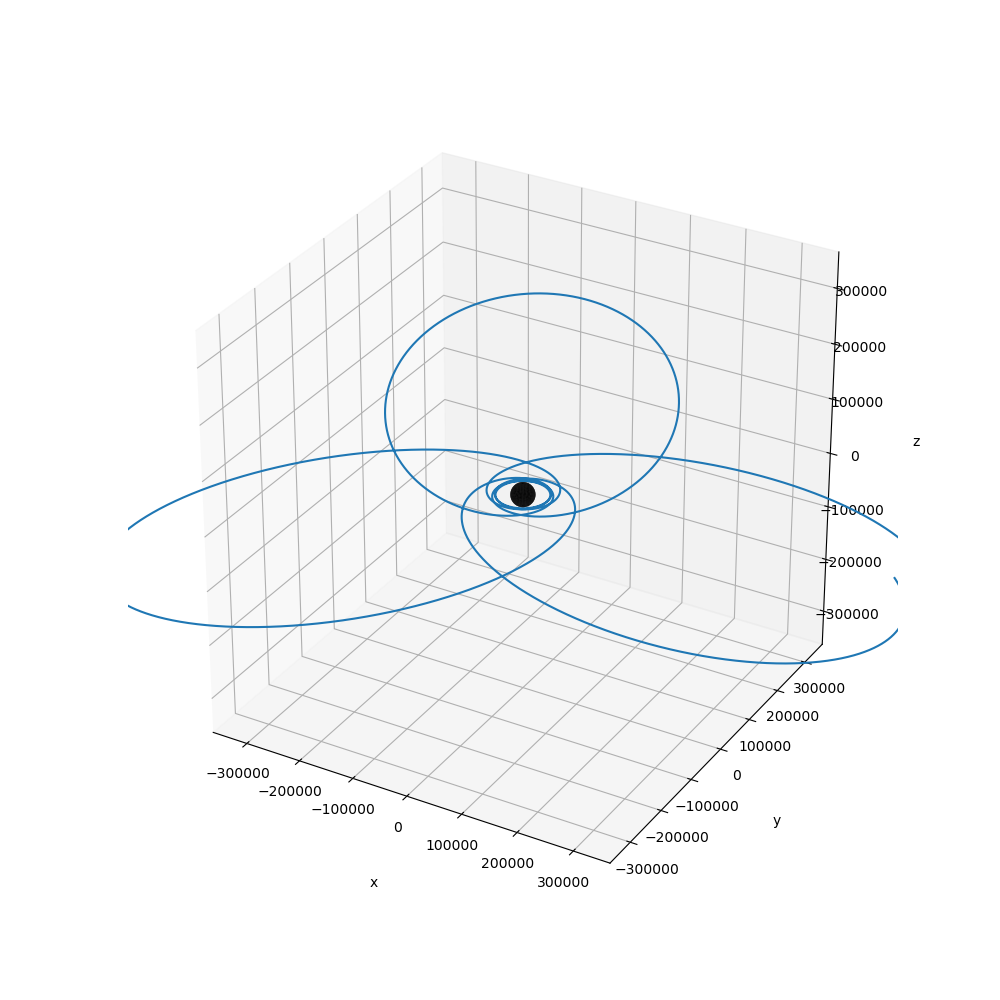

100000
[700000.         699999.99797948 699999.99191794 ... 626979.81249747
 626954.32874363 626928.84009878]
20000
30000


In [52]:
Theta = sol.y[4,:]
Phi = sol.y[6,:]
X = sol.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol.y[0,:] * np.round(np.cos(Theta),14)

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()

ax1.plot3D(X,Y,Z)

#Plotting meant for Kerr
shwr_R = 2*G*M
J=0

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_shwr = shwr_R * np.outer(np.cos(u), np.sin(v))
y_shwr = shwr_R * np.outer(np.sin(u), np.sin(v))
z_shwr = shwr_R * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

#'b' is blue, 'k' is black, 'r' is red
ax1.plot_surface(x_shwr,y_shwr,z_shwr, color = 'k')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.0)

zoom = 2

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()

print(len(sol.y[0,:]))
print(sol.y[0,:])
print(2*G*M)
print(3*G*M)

In [78]:
R_final = 5*G*M
s = 0
for i in range(0, len(sol.y[0,:])):
    if sol.y[0,i] < R_final:
        s = i
        break
    
def event(t, y):
    y = sol.y
    return R_final-y[0,s]

print(s)
sol2 = solve_ivp(system_of_odes, t_span, initial_conditions, method='DOP853', t_eval = t_eval, events=[event], rtol = 1e-8, atol = 1e-10)
print(sol2)

15375
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 2543
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000e+00, 5.00005e+02, 1.00001e+03, ..., 4.99990e+07,
       4.99995e+07, 5.00000e+07])
 t_events: [array([], dtype=float64)]
        y: array([[ 7.00000000e+05,  6.99999998e+05,  6.99999992e+05, ...,
         6.26979812e+05,  6.26954329e+05,  6.26928840e+05],
       [ 0.00000000e+00, -8.31968963e-06, -1.66393793e-05, ...,
        -5.26413096e-02, -5.26514842e-02, -5.26616595e-02],
       [ 0.00000000e+00, -5.08091477e+02, -1.01618295e+03, ...,
        -5.29870695e+07, -5.29875793e+07, -5.29880892e+07],
       ...,
       [ 1.57079633e+00,  1.57079633e+00,  1.57079633e+00, ...,
         1.57079633e+00,  1.57079633e+00,  1.57079633e+00],
       [ 0.00000000e+00,  9.50360414e-17,  1.90072084e-16, ...,
         3.07475679e-11,  3.07451015e-11,  3.07426397e-11],
       [ 0.00000000e+00,  3.9796316

<IPython.core.display.Javascript object>


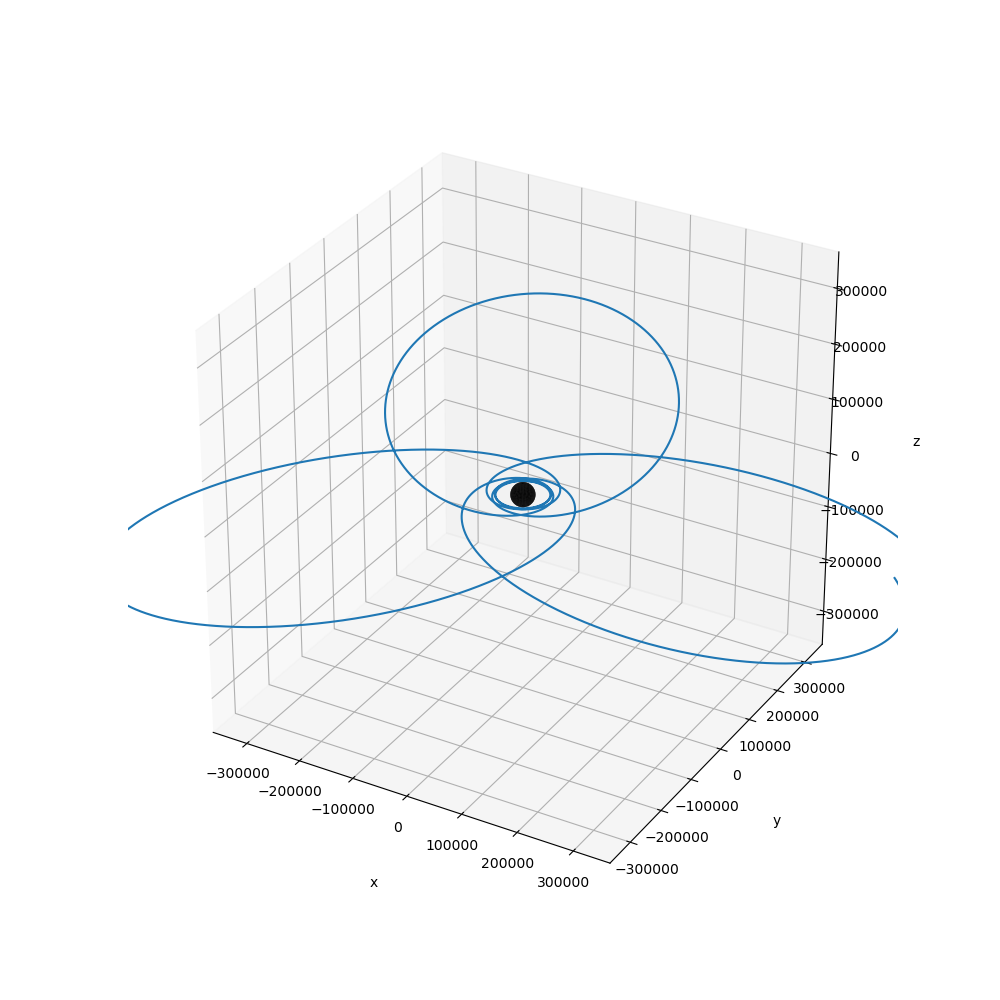

In [77]:
Theta = sol2.y[4,:]
Phi = sol2.y[6,:]
X = sol2.y[0,:] * np.sin(Theta) * np.cos(Phi)
Y = sol2.y[0,:] * np.sin(Theta) * np.sin(Phi)
Z = sol2.y[0,:] * np.round(np.cos(Theta),14)

fig3 = plt.figure(figsize = (10,10))
ax1 = plt.axes(projection='3d')
ax1.grid()

ax1.plot3D(X,Y,Z)

#Plotting meant for Kerr
shwr_R = 2*G*M
J=0

u = np.linspace(0, 2. * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_shwr = shwr_R * np.outer(np.cos(u), np.sin(v))
y_shwr = shwr_R * np.outer(np.sin(u), np.sin(v))
z_shwr = shwr_R * np.outer(np.ones(np.size(u)), np.cos(v))

x_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.cos(u), np.sin(v))
y_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.sin(u), np.sin(v))
z_ergo = (M + np.sqrt(M**2 - (J/M)**2 * np.cos(v)**2)) * np.outer(np.ones(np.size(u)), np.cos(v))

#'b' is blue, 'k' is black, 'r' is red
ax1.plot_surface(x_shwr,y_shwr,z_shwr, color = 'k')
ax1.plot_surface(x_ergo, y_ergo, z_ergo, color = 'r', alpha = 0.0)

zoom = 2

ax1.set_xlim([-R/zoom, R/zoom])
ax1.set_ylim([-R/zoom, R/zoom])
ax1.set_zlim([-R/zoom, R/zoom])

ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x', labelpad=20)
ax1.set_ylabel('y', labelpad=20)
ax1.set_zlabel('z', labelpad=20)

plt.show()